$\newcommand{\R}{\mathbb{R}}$
$\newcommand{\transp}{\mathrm{T}}$

# 1. Context 

Our ultimate motivation is to design and improve reachability analysis methodologies for single and hybrid non-linear control systems. Here we will restrict to those single systems which can be written as
$$
\dot{x} = f(x,t) + g(x,t)u + h(x,t)w,
$$
where $x$ is the *state*, and $f, g, h$ are vector fields of the appropriate dimensions, $u$ is controlled input, and $w$ is an uncontrolled input (e.g. noise). They are often assumed sufficiently regular (Lipshitz continuous), to ensure existence and uniqueness of solutions. The reachability problem is associated to finding the sets in state-space in which the system occupies, often upon restrictions on the initial set (hence we are interested in the *forward-reachable set*), or the final or target set (hence we want to compute the *backward-reachable set*). Moreover, both finite and infinite time horizons are interesting. Hereafter we focus on the FRS for finite time horizon.

The problem of reachability is closely related to generating approximations of ODE solutions. We can highlight:
1. In *numerical integration*, one solves iteratively the ODE, with a step-size that can be used to control the local approximation error. This method does not provide guaranteed integration, hence it is not suitable for the purpose of verification.
2. In *validated integration*, there are two main approaches: (i) in the *discrete*, one discretizes time and approximates the reach pipe sequentially, and the over-approximation is guaranteed by an appropriate bloating factor; (ii) in the *continuous* case, one comes up with another differential equation, whose solution is known to provide an appropriate enclosure of the solution of the objective system.

**Remark**. By no means we attempt to address the relevant literature on validated integration techniques. The literature is vast and vibrant, and the interested reader is suggested to look at numerous recent thesis on this subject (e.g. from the 2000s onwards).

# 2. Preliminaries

The following concepts will be used throughout the tutorial. In all these definitions we are implicitly in the familiar Euclidean space $\R^n$, though all of them make sense in one way or another in an abstract metric space.

## 2.1. Convex sets

A [convex set](https://en.wikipedia.org/wiki/Convex_set) is a region such that, for every pair of points within the region, every point on the straight line segment that joins the pair of points is also within the region. 

## 2.2. Convex hull

The [convex hull](https://en.wikipedia.org/wiki/Convex_hull) of a set $X \subseteq \R^n$ is the smallest convex sets that contains $X$.

*Exercise*. Have a look at the docs for [convex hull](http://doc.sagemath.org/html/en/reference/geometry/sage/geometry/polyhedron/base.html?highlight=convex_hull#sage.geometry.polyhedron.base.Polyhedron_base.convex_hull). Try the example. We will make heavy use of the Polyhedron class in this tutorial.

## 2.3. Hausdorff distance and norms 

Recall that the $p$-norm of $x \in \R^n$ ($1\leq p <\infty$) is $||x||_p = \left( \sum_i |x_i|^p \right)^{1/p}$; the supremum norm ($p=\infty$) is $||x||_\infty = \max_i |x_i|$. The reason of the constraint $p \geq 1$ is due to the fact that we loose convexity if we allow $p<1$. In most applications, convexity is a desired property. This is illustrated in the figures below:
![alt text](http://upload.wikimedia.org/wikipedia/commons/e/e6/Minkowski3.png "p-norm")

The [Hausdorff distance](https://en.wikipedia.org/wiki/Hausdorff_distance) is a concept that generalizes the notion of distance between points, to distance between *sets of points*. To understand why we need a generalization, think of the following: what would be a reasonable distance between the yellow semidisk and the orange line? between the blue line and the semidisk? between both lines?

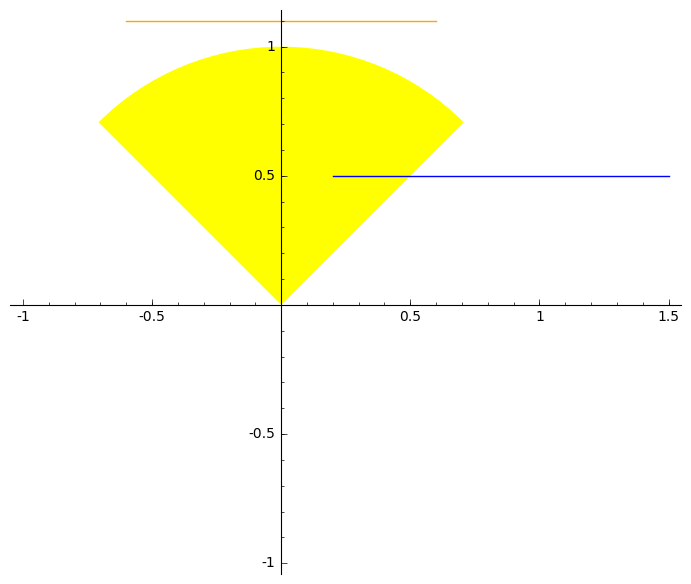

In [1]:
disk((0.0,0.0), 1, (pi/4,3*pi/4) ,rgbcolor=(1,1,0)) + line([[0.2,0.5], [1.5,0.5]]) + line([[-0.6,1.1], [0.6,1.1]],color='orange')

More precisely, in the Euclidean space $(\R^n,||\cdot||_p)$ the Hausdorff distance between the sets $X$ and $Y$ is defined as
$$
d^H_p(X,Y) = \max \left\{ \sup_{x \in X} \inf_{y \in Y} ||x-y||_p , \sup_{y \in Y} \inf_{x \in X} ||x-y||_p \right\}.
$$
It is worth doing some examples by hand to convince you that this formulation makes sense.

*Exercise*. Answer the questions in relation to the previous plot using the definition of Hausdorff distance, with $p=2$ (usual Euclidean norm). How does the result change with different values of $p$?

## 2.3. Support function

Let $\Omega \subset \mathbb{R}^n$ be a compact convex set. The support function of $\Omega$, $\rho_\Omega : \mathbb{R}^n \to \mathbb{R}$, is defined as 
\begin{equation}
\rho_\Omega(d) = \max_{x \in \Omega}~~ d^\mathrm{T}\cdot x
\end{equation}
A polyhedral over-approximation of $\Omega$ can be built via support functions.

**Proposition**. Let $\{\ell_1,\ldots,\ell_r\}$ be a family of chosen vectors in $\R^n$. Let define the half-spaces $H_k = \{ x \in \R^n: \ell_k^\transp \cdot x \leq \rho_\Omega(\ell_k)\}$ for all $k=1,\ldots,r$. Then:
1. The polyhedron $\bar{\Omega} := \bigcap\limits_{k = 1}^r H_k$ is an over-approximation of $\Omega$, that is, $\Omega \subseteq \bar{\Omega}$.
2. The over-approximation is *tight*, in the sense that $\Omega$ touches the faces of $\bar{\Omega}$.


### 2.3.1. Support function of a convex polytope

If $\Omega$ is a convex polytope, $\Omega = \{ x \in \mathbb{R}^n:~Ax \leq b\}$, then its support function is equivalent to solving the [linear program](https://en.wikipedia.org/wiki/Linear_programming) (LP):
\begin{equation}
\rho_\Omega(d) = \text{max} \{ d^\mathrm{T}\cdot x :~ Ax \leq b \}
\end{equation}
Below we implement this function. The class Polyhedron saves the inequalities as [b,A], with the convention that $Ax+b\geq 0$, so we have to be careful if we use the convention $Ax \leq b$.

In [2]:
#Compute support function of a convex polytope (given as (A,b), assuming: Ax <= b)
def supp_fun_polyhedron(d, P, showOutput=1): 
    
    s_LP = MixedIntegerLinearProgram(maximization=True, solver = "GLPK")
    x = s_LP.new_variable(integer=False, nonnegative=False)

    # objective function
    obj = sum(d[i]*x[i] for i in range(len(d)))
    s_LP.set_objective(obj)
    
    # extract the constraints from P
    m = len(P.Hrepresentation())
    n = len(vector( P.Hrepresentation()[0] ))-1
    b = vector(RR, m)
    A = matrix(RR, m, n)
    P_gen = P.Hrep_generator();
    i=0
    for pigen in P_gen:
        pi_vec = pigen.vector()
        A.set_row(i, -pi_vec[1:len(pi_vec)])
        b[i] = pi_vec[0]
        i+=1;
        
    s_LP.add_constraint(A * x <= b);    
        
    if (showOutput):
        print '**** Solve LP (using GLPK) ****'    
        s_LP.show()
    
    oval = s_LP.solve()
    xopt = s_LP.get_values(x);
    
    if (showOutput):
        print 'Objective Value:', oval
        for i, v in xopt.iteritems():
            print 'x_%s = %f' % (i, v)
        print '\n'
    return oval, xopt

Let us compute the support function of the unit box at the $x=y$ direction:

In [4]:
P = Polyhedron(vertices=[[1,1],[-1,1],[-1,-1],[1,-1]],base_ring=RDF)
d = [1,1]
supp_fun_polyhedron(d, P, showOutput=1)

**** Solve LP (using GLPK) ****
Maximization:
  x_0 + x_1
Constraints:
  - x_1 <= 1.0
  - x_0 <= 1.0
  x_1 <= 1.0
  x_0 <= 1.0
Variables:
  x_0 is a continuous variable (min=-oo, max=+oo)
  x_1 is a continuous variable (min=-oo, max=+oo)
Objective Value: 2.0
x_0 = 1.000000
x_1 = 1.000000




(2.0, {0: 1.0, 1: 1.0})

### 2.3.2. Support function of an ellipse 

*Exercise*. What is the support function of an ellipsoid centered at the origin? 

*Answer*. Let $E = \{ x \in \R^n : x^\transp Q x \leq 1\}$, where $Q$ is a positive definite symmetric matrix. Then, $\rho_E(d) = \sqrt{d^\transp Q^{-1} d}$.

In [3]:
#Compute support function at d of an ellipse input as x^tr*Q*x <= 1
def supp_fun_ellipse(d, Q, showOutput=1): 
    if (Q.is_singular()):
        print 'error: input matrix is not invertible'
        return
    return sqrt(d.inner_product((~Q)*d))
    

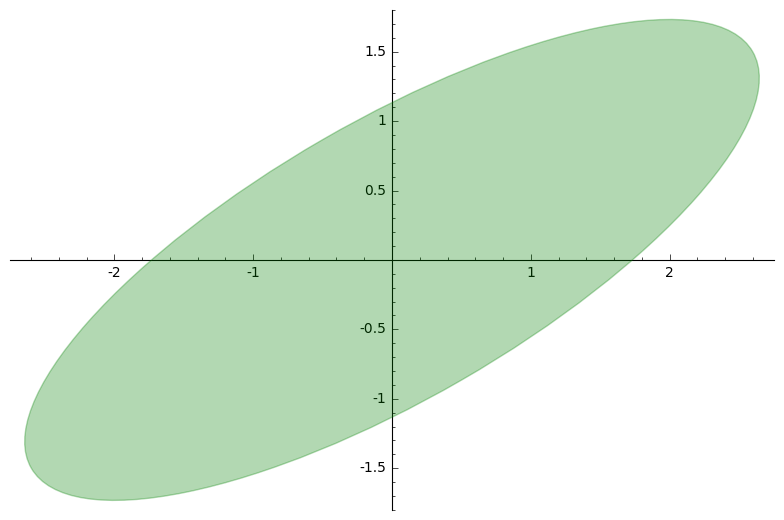

In [4]:
# build an ellipse centred at 0, with semiaxes 3 and 1, and tilted 30 deg counterclockwise
E = ellipse((0,0),3,1,pi/6,fill=True,edgecolor='black',facecolor='red',rgbcolor='green',alpha=0.3)
E

As shown in the previous cell, sagemath provides a command to plot an ellipse given the semiaxes and at a given angle wrt the coordinates axes. However I didn't find how to extract the $Q$ in one stroke (though this can be easily achieved [through a change of variables](http://www.maa.org/external_archive/joma/Volume8/Kalman/General.html)). Let us instead build the ellipse ourselves. In the way we will encounter the *implicit plot* feature.

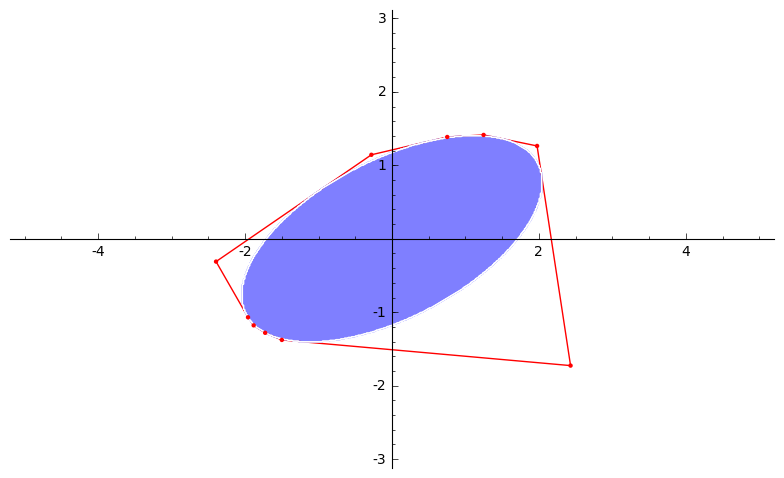

In [7]:
# Generate a random ellipsoid and plot using implicit plot
import random

# define an ellipse as: x^tr*Q*x <= 1
M = random_matrix(RR, 2, distribution="uniform")
Q = M.T*M
f = lambda x, y : Q[0,0]*x^2 + Q[1,1]*y^2 + (Q[0,1]+Q[1,0])*x*y-1
E = implicit_plot(f,(-5,5),(-3,3),fill=True,alpha=0.5,plot_points=600)

# Try out the overapproximation of an ellipse using support functions
import numpy as np
load("../Library/polyFunctions.sage")

# generate at random k directions, and compute the overapproximation of E using support functions
# works 'in average': we might get unbounded domains in some cases / 'frozen set'
k=10
A = matrix(RR,k,2); b = vector(RR,k)
for i in range(k):
    theta = random.uniform(0, 2*pi.n(digits=5))
    d = vector(RR,[cos(theta), sin(theta)])
    s_fun = supp_fun_ellipse(d, Q, showOutput=0)
    A.set_row(i,d); b[i] = s_fun

OmegaApprox = polytopeFromHrep(A, b)
E + OmegaApprox.plot(fill=False, color='red')